In [1]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")

In [2]:
split_data = ["LCK 2021 Spring.csv", "LCK 2021 Summer.csv", "LCK 2022 Spring.csv", "LCK 2022 Summer.csv"]
mvp_data = ['2021_spring.csv', '2021_summer.csv', '2022_spring.csv', '2022_summer.csv']

splits = []

In [10]:
for index in range(0, 4):
    split = pd.read_csv(split_data[index])
    
    # filter out players with less than 10 games
    split = split[split['GP'] >= 10]
    
    # add a year and season indicator to each player data
    split['Year'] = str(split_data[index][4:8])
    split['Season'] = split_data[index][9:15]
    
    # special case where ShowMaker (the absolute monster) played ADC (10 games) (Ghost got benched)
    # and many more Mid in DWG for '21 Spring
    # his Pog points are counted the same, but he is represented as two separate roles
    # we take the decision to remove ShowMaker ADC from the list
    # when ShowMaker played ADC, his jungler Canyon filled into mid. During this time,
    # Malrang was trying out for the jungle role. He eventually left to join KOI (then Rogue) 
    # in the LEC region 
    if split['Year'].iloc[0] == '2021' and split['Season'].iloc[0] == 'Summer':
        #print(split.shape)
        split = split[~((split['Player'] == 'ShowMaker') & (split['Pos'] == 'ADC'))]
        split = split[~((split['Player'] == 'Canyon') & (split['Pos'] == 'Middle'))]
        #print(split.shape)
        
    exclude = ['Player', 'Team', 'Pos', 'Year', 'Season']
    incldue = [col for col in split.columns if col not in exclude]
    for cols in incldue:
        for idx, val in split[cols].items():
            if str(val).endswith("%"):
                split.at[idx, cols] = str(val.strip("%"))

    split[incldue] = split[incldue].astype('float64')
    split = split.sort_values(by=['KDA', 'K', 'D', 'A', 'DPM', 'GD10'])
    mvp_cur = pd.read_csv(mvp_data[index])
    mvp_cur = mvp_cur.sort_values(by=['KDA', 'K', 'D', 'A', 'DPM', 'GD10'])
    mvplist = mvp_cur['MVP'].reset_index(drop=True)
    split = split.reset_index(drop=True)
    split['MVP'] = mvplist
    splits.append(split)
    

In [11]:
from sklearn.preprocessing import MinMaxScaler
def scale_split(df):
    scaler = MinMaxScaler()
    numerical_columns = df.select_dtypes(include='number').columns
    #print(numerical_columns)
    scaled_df = df.copy()
    
    scaled_df[numerical_columns] = scaler.fit_transform(df[numerical_columns])
    non_numeric_columns = df.select_dtypes(exclude='number').columns
    #print(non_numeric_columns)
    scaled_df[non_numeric_columns] = df[non_numeric_columns]
    
    return scaled_df

In [12]:
scaled_splits = []
for split in splits:
    scaled = scale_split(split)
    scaled_splits.append(scaled)
whole_set = pd.concat(scaled_splits, ignore_index=True)

In [13]:
narows = whole_set[whole_set['MVP'].isnull()]
print(narows)
# no rows have NA values for MVP, values have been properly filled

Empty DataFrame
Columns: [Player, Team, Pos, GP, W%, CTR%, K, D, A, KDA, KP, KS%, DTH%, FB%, GD10, XPD10, CSD10, CSPM, CS%P15, DPM, DMG%, D%P15, EGPM, GOLD%, STL, WPM, CWPM, WCPM, Year, Season, MVP]
Index: []

[0 rows x 31 columns]


In [ ]:
<Note: shift the copying over of MVP from main code to side code>

In [20]:
#whole_set[['Player', 'MVP']].sort_values(by='MVP', ascending=False).head(5)
whole_set = whole_set.dropna(axis=1)
whole_set_vals = whole_set.select_dtypes(include='number')
whole_set_vals = whole_set_vals.drop(['GP', 'MVP'], axis=1)
whole_set_labels = whole_set.select_dtypes(exclude='number')
whole_set_labels = pd.concat([whole_set_labels, whole_set[['GP', 'MVP']]], axis=1)

# drop the columns 
# games played (represented as 'GP') (More games played = more chances to receive MVP, not a great indicator)
# MVP (represented as 'MVP') (What we want to use a ranking/class/predictor)
# from the list whole_set
role_sets = []
role_sets_labels = []
role_sets_vals = []

In [21]:
positions = list(set(whole_set_labels['Pos']))

# generating 5 sets of data for players in each role
for position in positions:
    role_sets.append(whole_set[whole_set['Pos'] == position])
    role_sets_labels.append(whole_set_labels[whole_set_labels['Pos'] == position])
    role_sets_vals.append(whole_set_vals[whole_set_labels['Pos'] == position])

In [22]:
role_sets[positions.index("ADC")].sort_values(by='KDA', ascending=False).head()

,Player,Team,Pos,GP,W%,CTR%,K,D,A,KDA,...,DPM,DMG%,EGPM,GOLD%,WPM,CWPM,WCPM,Year,Season,MVP
119,Teddy,T1,ADC,0.236842,0.685185,0.323944,0.312849,0.081481,0.196262,1.000000,...,0.942553,0.897638,0.875000,0.86802,0.377483,0.157895,0.775,2021,Summer,0.272727
344,Teddy,T1,ADC,0.236842,0.685185,0.323944,0.312849,0.081481,0.196262,1.000000,...,0.942553,0.897638,0.875000,0.86802,0.377483,0.157895,0.775,2021,Summer,0.272727
449,Ruler,Gen.G,ADC,0.812500,1.000000,0.452381,1.000000,0.177966,0.419355,1.000000,...,1.000000,0.965517,0.988506,0.85782,0.209877,0.292683,1.000,2022,Summer,1.000000
224,Ruler,Gen.G,ADC,0.812500,1.000000,0.452381,1.000000,0.177966,0.419355,1.000000,...,1.000000,0.965517,0.988506,0.85782,0.209877,0.292683,1.000,2022,Summer,1.000000
56,Teddy,T1,ADC,0.351351,0.940000,0.716981,0.527174,0.179688,0.324022,0.791667,...,0.975560,0.879167,0.987395,0.89372,0.279762,0.166667,0.500,2021,Spring,0.400000


In [24]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

predicted_labels = []
for role in positions:
    labels = []
    silhouettes = []
    max_silhouette = -1
    max_silhouette_cluster = None
    for num in range(2, 10):
        my_set = role_sets[positions.index(role)]
        my_set_vals = role_sets_vals[positions.index(role)]
        my_set_labels = role_sets_labels[positions.index(role)]
        kmeans = KMeans(n_clusters=num, random_state=42)
        kmeans.fit(my_set_vals)
        labels.append(kmeans.labels_)
        silhouette_avg = silhouette_score(my_set_vals, labels[num-2])
        #print("Silhouette score for role", role , " at clusters", num, ": ", silhouette_avg)
        silhouettes.append(silhouette_avg)
        if silhouette_avg > max_silhouette:
            max_silhouette = silhouette_avg
            max_silhouette_cluster = kmeans.labels_
    print("Max silhouette score for role", role, "at clusters", silhouettes.index(max_silhouette) + 2, ": ", max_silhouette)
    predicted_labels.append(max_silhouette_cluster)
    

Max silhouette score for role Middle at clusters 2 :  0.24969841132001955
Max silhouette score for role ADC at clusters 2 :  0.2492677078500539
Max silhouette score for role Top at clusters 8 :  0.25699124703660975
Max silhouette score for role Jungle at clusters 9 :  0.2790653351286389
Max silhouette score for role Support at clusters 8 :  0.23924970573015275


Silhouettes scores are less than 0.3 across the board, suggesting that the available data is not enough to classify each role into different playstyles, or that there is no particular difference between player playstyles

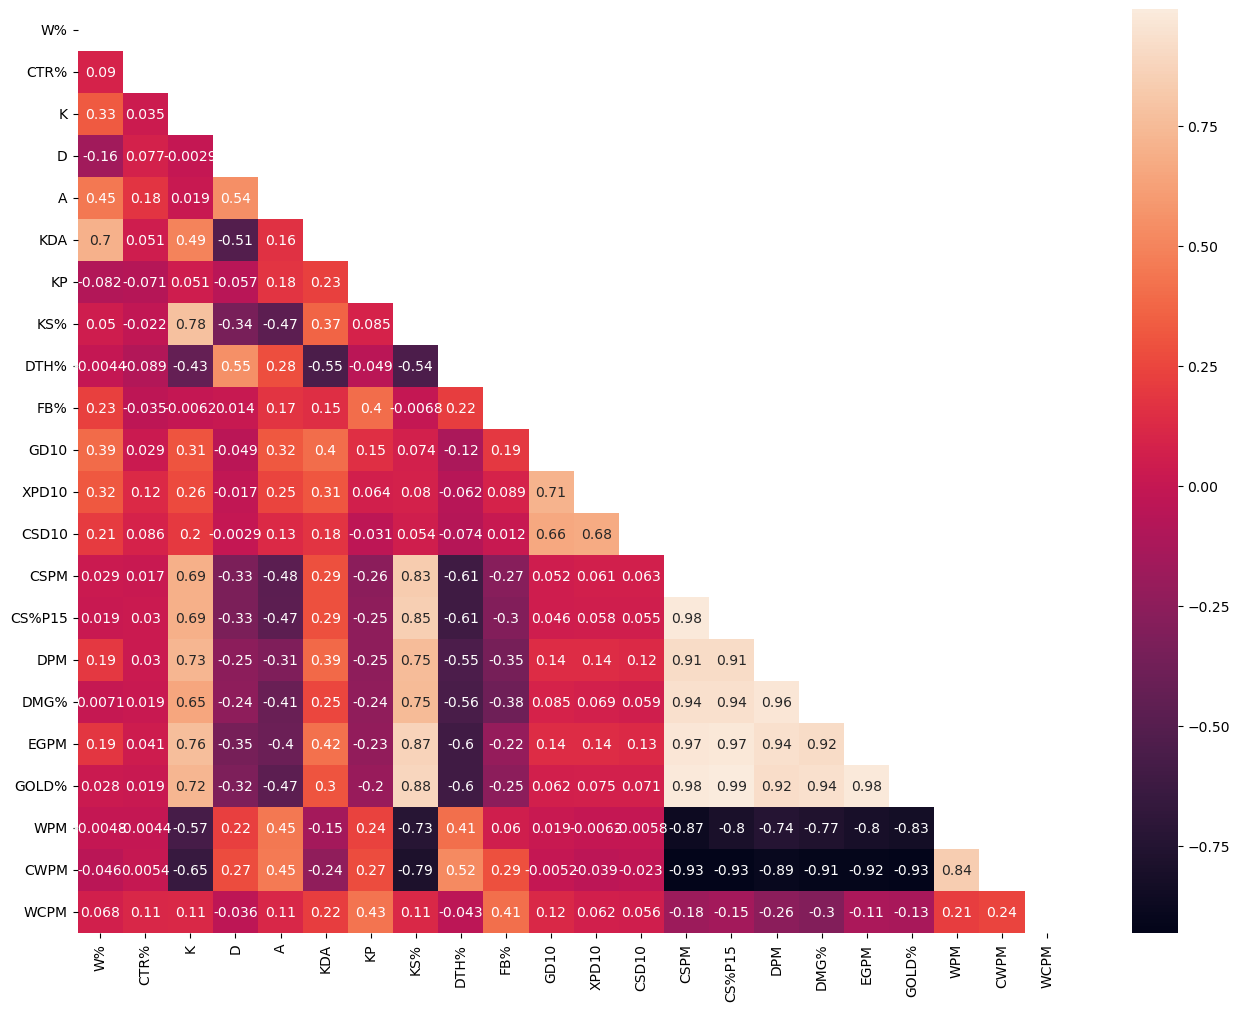

In [25]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(16, 12))
mask = np.triu(np.ones_like(whole_set_vals.corr(), dtype=bool))

heatmap = sns.heatmap(whole_set_vals.corr(), mask=mask, annot=True)

plt.show()

In [27]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
role_vifs = []
for role in positions:
    vifs = pd.DataFrame()
    my_set = role_sets[positions.index(role)]
    my_set_vals = role_sets_vals[positions.index(role)]
    #my_set_labels = role_sets_labels[positions.index(role)]
    vifs['features'] = my_set_vals.columns
    vifs['VIF'] = [variance_inflation_factor(my_set_vals.values, i)
                            for i in range(len(my_set_vals.columns))]
    role_vifs.append(vifs)

In [28]:
for role in positions:
    vifs = role_vifs[positions.index(role)]
    print("VIFs for Role :", role)
    print(vifs.sort_values(by='VIF', ascending=False).head())
# shows us that gold%, egpm, etc are highly dependant on other stats.
# eg. gold% is from higher cspm, higher kills, higher gd@10, etc.

VIFs for Role : Middle
   features          VIF
18    GOLD%  3425.027400
14   CS%P15  3044.840862
13     CSPM  1689.219510
17     EGPM  1622.937819
15      DPM   638.404246
VIFs for Role : ADC
   features          VIF
18    GOLD%  4842.761937
14   CS%P15  3292.795233
13     CSPM  2110.172899
17     EGPM  2073.375773
16     DMG%   644.509769
VIFs for Role : Top
   features          VIF
18    GOLD%  5708.639156
14   CS%P15  5543.919730
17     EGPM  3454.360378
13     CSPM  3020.827993
16     DMG%   862.302441
VIFs for Role : Jungle
   features          VIF
18    GOLD%  3354.011325
17     EGPM  1999.020108
14   CS%P15  1019.581535
15      DPM   525.374423
16     DMG%   499.668364
VIFs for Role : Support
   features         VIF
19      WPM  232.050195
4         A  228.138267
17     EGPM  188.723110
3         D  140.289791
20     CWPM  130.821981


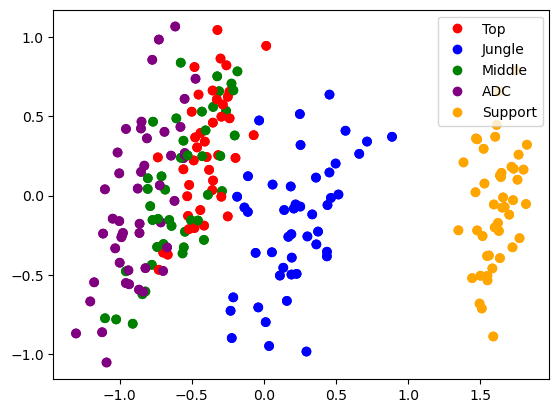

In [29]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(n_components=2)
X_pca = pca.fit_transform(whole_set_vals)

label_color_map = {
    'Top': 'red',
    'Jungle': 'blue',
    'Middle': 'green',
    'ADC': 'purple',
    'Support': 'orange'
}

colors = np.array([label_color_map[label] for label in whole_set_labels['Pos']])


fig, ax = plt.subplots()
scatter = ax.scatter(X_pca[:, 0], X_pca[:, 1], c=colors, 
                     label=whole_set_labels['Pos'])

# Add labels to the points
#for i, txt in enumerate(larger_dataset_labels['Pos']):
#    ax.annotate(txt, (X_pca[i, 0], X_pca[i, 1]))

legend_elements = [plt.Line2D([0], [0], marker='o', color=color, 
                              label=label, linestyle='') for label, color in label_color_map.items()]
ax.legend(handles=legend_elements, loc='best')

plt.show()

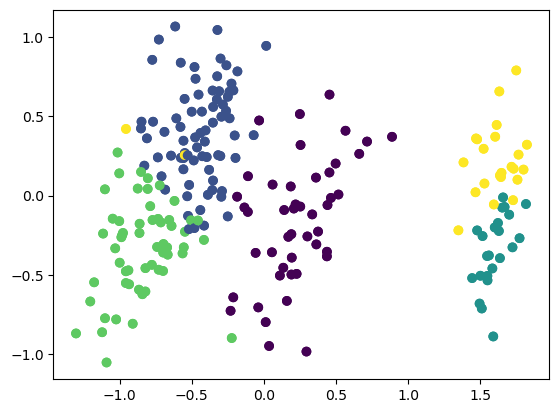

In [31]:
from sklearn.cluster import SpectralClustering

# Perform PCA with 5 components
pca = PCA(n_components=6)
X_pca = pca.fit_transform(whole_set_vals)

# Apply spectral clustering to the transformed data
spectral = SpectralClustering(n_clusters=5, assign_labels='discretize', random_state=42)
spectral_labels = spectral.fit_predict(X_pca)

plt.scatter(X_pca[:, 0], X_pca[:, 1], c=spectral_labels)
plt.show()

In [35]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
mvp_encoded = label_encoder.fit_transform(whole_set_labels['MVP'])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(whole_set_vals, mvp_encoded, test_size=0.2, random_state=42)

# Train the XGBoost classifier
clf = xgb.XGBClassifier(objective='multi:softmax', num_class=5, max_depth=5, learning_rate=0.1, n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# Predict on the test set
y_pred = clf.predict(X_test)

# Evaluate the accuracy of the classifier
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy (in predicting MVP scores): %.2f%% (with un-PCA\'d features)' % (accuracy * 100.0))


Accuracy (in predicting MVP scores): 84.44% (with un-PCA'd features)


In [37]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_pca, mvp_encoded, test_size=0.2, random_state=42)

# Train the XGBoost classifier
clf = xgb.XGBClassifier(objective='multi:softmax', num_class=5, max_depth=5, learning_rate=0.1, n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# Predict on the test set
y_pred = clf.predict(X_test)

# Evaluate the accuracy of the classifier
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy: %.2f%% (with PCA\'d features)' % (accuracy * 100.0))

Accuracy: 86.67% (with PCA'd features)


Difference in accuracy when considering MVP values as labels is ~2% between un-PCA'd and PCA'd models

In [40]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression

estimator = LinearRegression()

rfe = RFE(estimator=estimator, n_features_to_select=10, step=1)
rfe.fit(whole_set_vals, whole_set_labels['MVP'])

print(whole_set_vals.columns[rfe.support_])

Index(['K', 'A', 'XPD10', 'CSPM', 'CS%P15', 'DMG%', 'EGPM', 'GOLD%', 'WPM',
       'CWPM'],
      dtype='object')


In [45]:
common_features = None
for role in positions:
    my_set_labels = role_sets_labels[positions.index(role)]
    my_set_vals = role_sets_vals[positions.index(role)]
    rfe = RFE(estimator=estimator, n_features_to_select=10, step=1)
    rfe.fit(my_set_vals, my_set_labels['MVP'])
    
    print("for role :", role)
    print(my_set_vals.columns[rfe.support_], "\n")
    
    if common_features is None:
        common_features = set(my_set_vals.columns[rfe.support_])
    else:
        common_features = common_features.intersection(set(my_set_vals.columns[rfe.support_]))
        
print("Common features across all roles:", common_features)

for role : Middle
Index(['W%', 'K', 'D', 'KDA', 'KP', 'KS%', 'CSPM', 'EGPM', 'GOLD%', 'WPM'], dtype='object') 

for role : ADC
Index(['K', 'D', 'KDA', 'FB%', 'XPD10', 'CSPM', 'DMG%', 'EGPM', 'GOLD%',
       'WPM'],
      dtype='object') 

for role : Top
Index(['W%', 'K', 'D', 'DTH%', 'XPD10', 'CSPM', 'CS%P15', 'DPM', 'GOLD%',
       'WPM'],
      dtype='object') 

for role : Jungle
Index(['A', 'KS%', 'GD10', 'CSD10', 'CSPM', 'DPM', 'DMG%', 'EGPM', 'GOLD%',
       'WCPM'],
      dtype='object') 

for role : Support
Index(['W%', 'K', 'A', 'KDA', 'KS%', 'CSPM', 'CS%P15', 'DMG%', 'GOLD%',
       'CWPM'],
      dtype='object') 

Common features across all roles: {'GOLD%', 'CSPM'}
